# [2024-01-09] Distribution of normalized syllables



We explore differences in usage per time bin across the vocabulary of behavioral syllables.

We find that 

In the binned killifish syllable usage data, we see large differences in
how often syllables are used per time bin.
For example, during the day, fish are more active, so the absolute syllable usage
for any single syllable usage is much lower because it is distributed over more syllables.
During the evening, however, fish are much less aciv

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from pathlib import Path
import sys

# Add `dtd` virtual environment
VENV_PATH = '/home/users/eyz/.envs/dtd/lib/python3.9/site-packages'

# Add `dirichlet-tucker` repo path. This should not be necessary...but it is
REPO_PATH = os.getcwd().split('/')
i_repo = REPO_PATH.index('dirichlet-tucker')
REPO_PATH = '/'.join(REPO_PATH[:i_repo+1])

# Add the analysis folder path so we can access local utils. This should also
# not be necessary since these files are in the same folder as this notebook,
# but looks like the paths are pretty variable and moody on Sherlock OnDemand
# SO we're just going to leave everything in the parent folder so that I don't
# break anything and because putting it in the same folder as this does not gain
# us anything...
ANALYSIS_PATH = os.path.join(Path(REPO_PATH), 'analysis')

for path in [VENV_PATH, REPO_PATH, ANALYSIS_PATH]:
    if path not in sys.path:
        sys.path.insert(0, path)

In [3]:
import dataclasses
from functools import partial
import itertools

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from killifish import load_data
from kf_viz import (
    LIFESPAN_CMAP,
    make_tod_series,
    set_syllable_cluster_ticks,
    SYLLABLE_PERM,
    SYLLABLE_PERM_DICT,
)


/share/software/user/open/py-scipy/1.6.3_py39/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/users/eyz/.envs/dtd/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/home/users/eyz/.envs/dtd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Utils**

In [4]:
def set_tod_ticklabels(ax, axis='x', tod_freq: str='4H'):
    B = 144                                              # num time bins per day
    
    t_dts = make_tod_series(tod_freq)
    
    t_locs = np.concatenate(
        [np.linspace(0, B, num=len(t_dts), endpoint=False), [B]]
    )
    
    t_labels = list(map(lambda dt: dt.strftime('%H'), t_dts)) + ['24']

    if axis == 'x':
        ax.set_xticks(t_locs)
        ax.set_xticklabels(t_labels)
    elif axis == 'y':
        ax.set_yticks(t_locs)
        ax.set_yticklabels(t_labels)
    else:
        raise ValueError(f"Expected `axis` to 'x' or 'y', but got {axis}.")
                             
    return t_locs, t_labels

**Load data**

In [5]:
@dataclasses.dataclass
class Killifish:
    syllable_counts: np.ndarray                   # shape (n_days, n_bins, n_syllables)
    ages: np.ndarray                             # shape (n_days,)
    name: str
    lifespan: int=dataclasses.field(init=False)
    category: str=dataclasses.field(init=False)  # {'short', 'median', 'long'}

    def __post_init__(self,):
        # Permute the syllables!
        self.syllable_counts = self.syllable_counts[..., SYLLABLE_PERM]
        
        # Set easy-access attributes
        self.lifespan = self.ages[-1]
        
        if self.lifespan < 120:
            self.category = 'short'
        elif self.lifespan < 280:
            self.category = 'median'
        else:
            self.category = 'long'
        

In [6]:
DATA_DIR = Path('/scratch/groups/swl1/killifish/p3_20230726-20230915/q2-aligned_10min')
TOTAL_COUNTS_PER_BIN, syllable_counts, subject_ages, subject_names, _ = load_data(DATA_DIR)

2024-01-13 20:15:17.454915: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
# Seperating data out by fish is not necessary for this notebook -- we will
# largely find ourselves using the original `syllable_counts` variable because
# we are examining subject-agnostic syllable usage statistics.
# However, we'll keep this here just because it may be useful for the future.
_, subject_idxs = np.unique(subject_names, return_index=True)

itr = zip(
    np.split(syllable_counts, subject_idxs[1:]),
    np.split(subject_ages, subject_idxs[1:]),
    subject_names[subject_idxs]
)

# Store all data in a list, by subject
kf_by_fish = [
    Killifish(syllable_counts=counts, ages=ages, name=name)
    for counts, ages, name in itr
]

# Sort list so that it's in ascending order of lifespan (shortest -> longest)
kf_by_fish.sort(key=lambda kf: kf.lifespan)

In [8]:
# CONSTANTS
N_BINS_PER_DAY, N_SYLLABLES = syllable_counts.shape[1:]

# First index of each syllable cluster, assuming that syllables are already permuted
n_syllable_clusters = len(list(SYLLABLE_PERM_DICT.keys()))
syllable_cluster_idxs = np.concatenate(
    [[0,], np.cumsum([len(v) for v in SYLLABLE_PERM_DICT.values()])[:-1]]
)

# Syllable are not used uniformly

We inspect an upper-percentile of how each syllable is used, evaluated across
all fish.

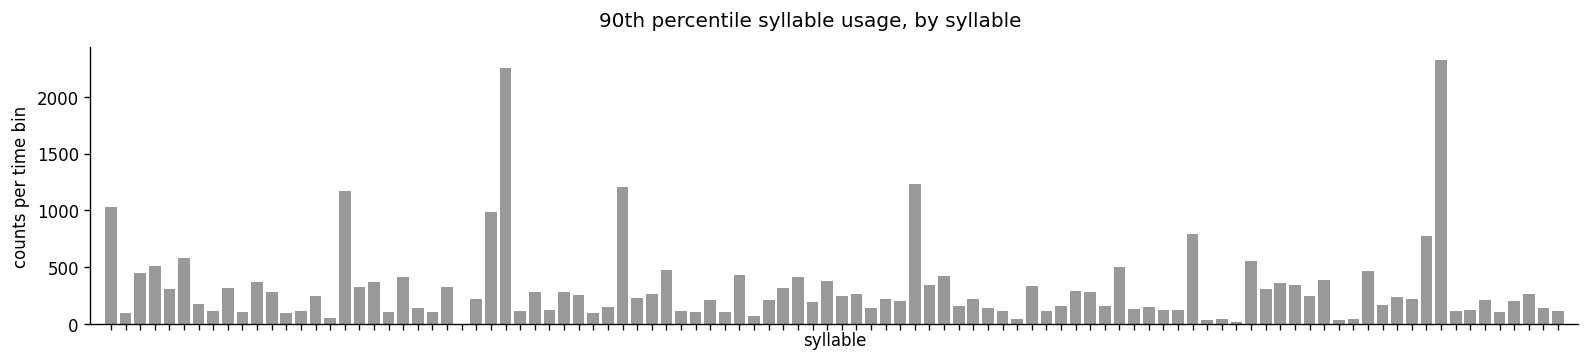

In [9]:
pct = 90

# =============================================================================
pct_counts_per_syllable = np.percentile(syllable_counts, pct, axis=(0,1))

fig, ax = plt.subplots(figsize=(16,3), dpi=120)
ax.bar(range(N_SYLLABLES), pct_counts_per_syllable, color='0.6')

ax.set_xlabel('syllable')
ax.set_xticks(range(N_SYLLABLES))
ax.tick_params(labelbottom=False)

ax.set_ylabel('counts per time bin')

ax.margins(x=0.01)

fig.suptitle(f"{pct}th percentile syllable usage, by syllable")
sns.despine()

**Figure** | 90th percentils counts per time bin vs. syllable.
There is large variability in how often each syllable --
there are large number of syllables which never appear to be highly used
in a any given time bin, while a select others can dominate the usage in a time bin.

**Syllables differ in the relative differences between daytime and nightime usage**

In [10]:
period_names = [
    'AM: 6AM-2PM',
    'PM: 2PM-10PM',
    'ZZ: 10PM-6AM',
]

# Construct masks for each period
n_bins_per_hr = N_BINS_PER_DAY // 24

# AM: 6AM - 2PM
am_mask = np.zeros(N_BINS_PER_DAY, dtype=bool)
am_mask[6*n_bins_per_hr:14*n_bins_per_hr] = True

# PM: 2PM - 10PM
pm_mask = np.zeros(N_BINS_PER_DAY, dtype=bool)
pm_mask[14*n_bins_per_hr:22*n_bins_per_hr] = True

# ZM (as in "zzz's o'clock"): 0-6AM, 10PM-12PM
zm_mask = np.zeros(N_BINS_PER_DAY, dtype=bool)
zm_mask[:6*n_bins_per_hr] = True
zm_mask[22*n_bins_per_hr:] = True

# Ensure that all masks are non overlapping
for i_cond, cond in enumerate([am_mask & pm_mask, am_mask & zm_mask, pm_mask & zm_mask]):
    assert all(cond==0), (
        "Expected masks to be mutually exclusive, " \
        + f"but found condition {i_cond} is overlapping."
    )

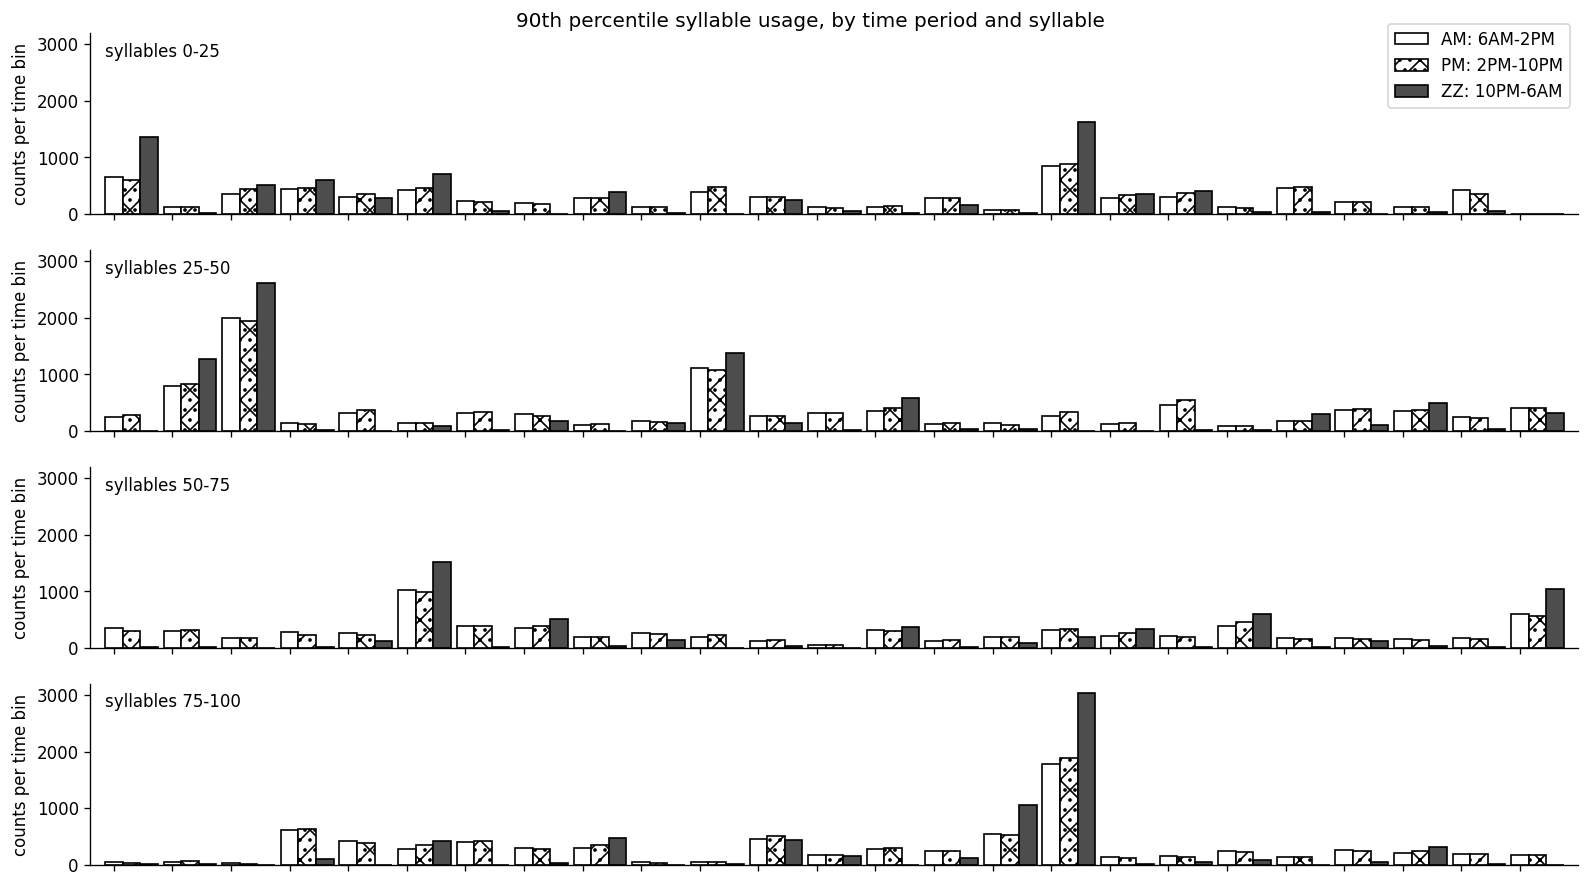

In [11]:
pct = 90
pct_counts_per_syllable_by_period = [
    np.percentile(syllable_counts[:,mask,:], pct, axis=(0,1))
    for mask in [am_mask, pm_mask, zm_mask]
]

# ==============================================================================
n_syllables_per_row = 25
n_groups = len(period_names)

nrows = int(np.ceil(N_SYLLABLES / n_syllables_per_row))
bar_width = 0.9 / n_groups

bar_kwargs = {
    period_names[0]: {'fc':'w', 'ec':'k'},
    period_names[1]: {'fc':'w', 'ec':'k', 'hatch':'//\..',},
    period_names[2]: {'fc':'0.3', 'ec':'k',},
}

fig, axs = plt.subplots(nrows=nrows, ncols=1, sharey='all',
                       figsize=(16, 9), dpi=120)

for i_row, ax in enumerate(axs):
    slc = slice(i_row*n_syllables_per_row, (i_row+1)*n_syllables_per_row)

    # Plot the 
    multiplier = 0
    for name, val in zip(period_names, pct_counts_per_syllable_by_period):
        offset = bar_width * multiplier
        rects = ax.bar(np.arange(n_syllables_per_row) + offset, val[slc],
                       bar_width, label=name, **bar_kwargs[name])
        multiplier += 1

    # Make pretty
    ax.margins(x=0.01)
    
    ax.set_xticks(range(n_syllables_per_row))
    ax.tick_params(labelbottom=False)

    ax.set_ylabel('counts per time bin')
    
    ax.text(0.01, 0.95, f'syllables {slc.start}-{slc.stop}', transform=ax.transAxes,
           va='top', fontsize='medium', weight='medium',)
    
axs[0].legend(loc='upper right', bbox_to_anchor=(1, 1.1))

fig.suptitle(f"{pct}th percentile syllable usage, by time period and syllable", fontsize='large', y=0.9)

sns.despine()


**Figure** | 90th percentile of syllable usage, split by time period.
As we saw previously, there is significant variability in usage across syllables.
We can further see that numerous syllables have different syllable usage
between daytime (_AM_ and _PM_) and nighttime (_ZZ_) time periods.
For example, syllables 50-54 (_row 3, first 4 syllables_) appear to have noticeable
difference in usage between daytime (_AM_ and _PM_) and nighttime (_ZZ_).

--- 
These two figures show the significant difference in the upper-percentile usage across syllables.
Using the raw counts (proportional to usage frequency relative to all syllables)
may in fact bias downstream analyses and predictions towards the syllables that have
the high upper-percentile usage.
Additionally, low-usage syllables which may have important differents in their daytime and nightime
syllable usage, for example, may likely be overlooked in downstream predictions
because the large relative difference in usage is still small by absolute scales.

This suggests that we should explore syllable-wise normalization schemes
that would be better allow our downstream models to identify important aging-related behavioral changes.

One approach that has been proposed is the min-max normalization that linearly scales the data
to all fall within [0,1], i.e. $(\min{x_v}, \max{x_v}) \rightarrow (0,1)$.
This normalization is a simple and straightforward approach, but it is susceptible to outliers.
We inspect the distribution of the syllable usage data to verify whether the min-max normalization
is a suitable approach.

# Syllable usage data has outliers

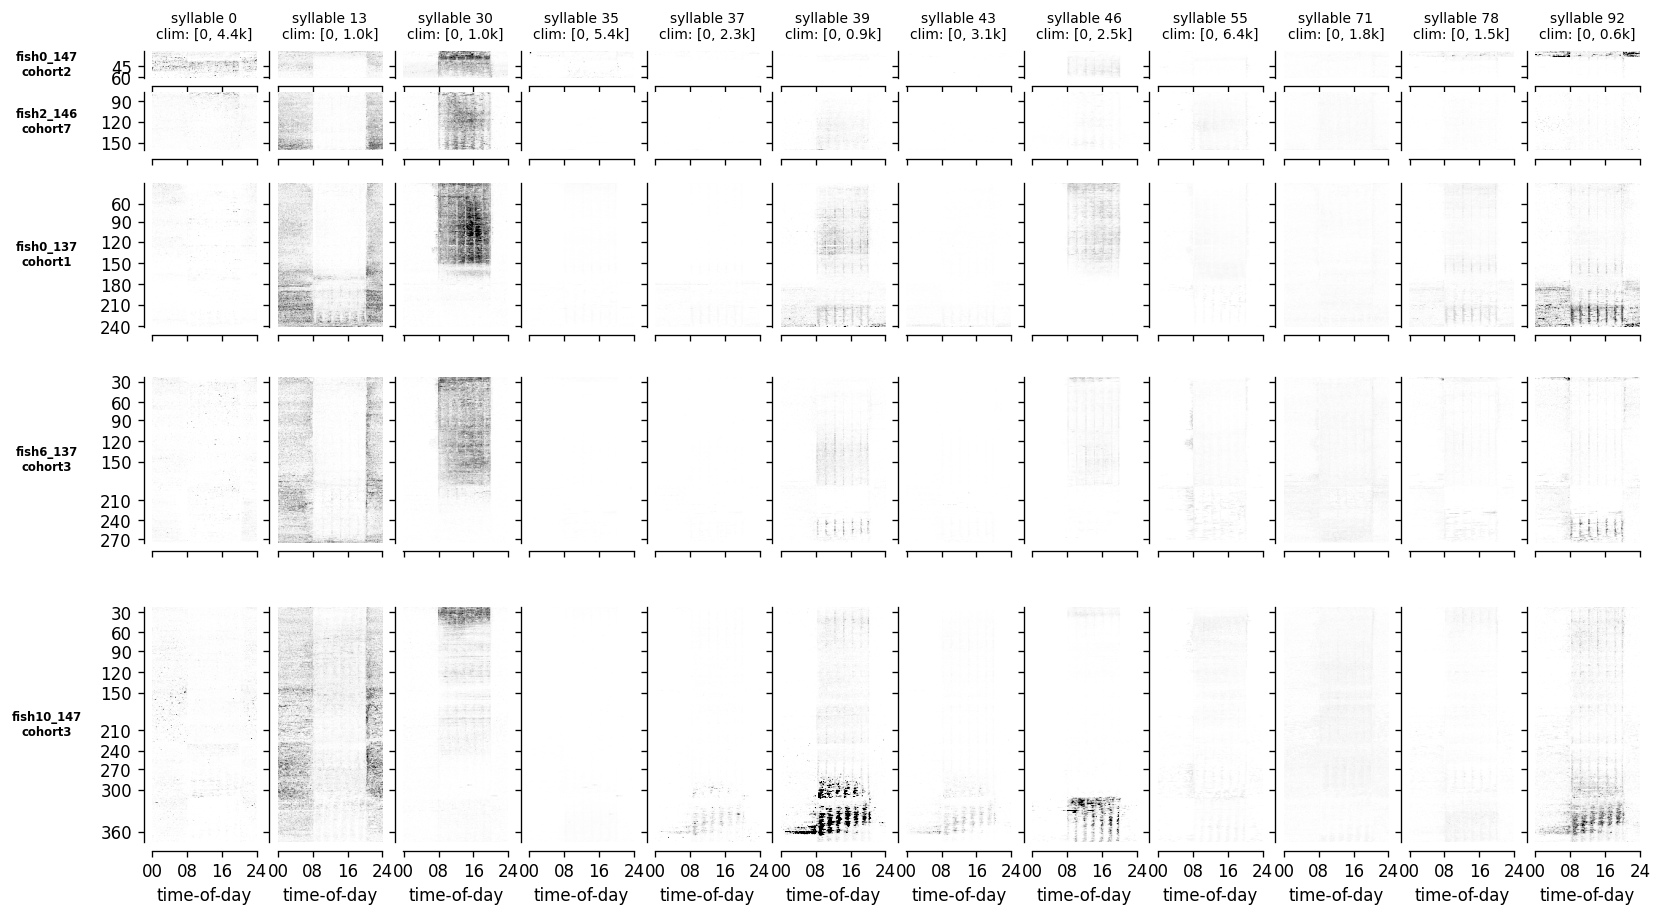

In [12]:
# Select some random subjects
selected_kf = [kf_by_fish[i_fish] for i_fish in [2, 20, 40, 60, 80]]

# =============================================================================

# Size rows based on number of days recorded
h_ratios = np.array([len(kf.ages) for kf in selected_kf], dtype=float)
h_ratios /= min(h_ratios)

gridspec_kw = dict(
    height_ratios = h_ratios,
    hspace=0.01,
)

fig, axs = plt.subplots(nrows=len(selected_kf), ncols=n_syllable_clusters,
                        squeeze=False,
                        gridspec_kw=gridspec_kw,
                        figsize=(16,9), dpi=120)

for i_col, syllable_idx in enumerate(syllable_cluster_idxs):
    max_counts = syllable_counts[..., syllable_idx].max(axis=(0,1))

    for i_row, kf in enumerate(selected_kf):

        ax = axs[i_row, i_col]
        
        im = ax.imshow(kf.syllable_counts[:, :, syllable_idx],
                       cmap='Greys', vmin=0, vmax=max_counts)
        
        # Set x-ticks
        set_tod_ticklabels(ax, tod_freq='8h')
        
        # Set y-ticks
        day_freq = 15 if len(kf.ages) < 60 else 30
        iticks = np.nonzero(np.remainder(kf.ages, day_freq) == 0)[0]
        ax.set_yticks(iticks)
        ax.set_yticklabels(kf.ages[iticks])

        ax.tick_params(labelleft=False, labelbottom=False)
        
        # First row
        if i_row == 0:
            ax.set_title(f"syllable {syllable_idx}\nclim: [0, {max_counts/1e3:.1f}k]",
                         fontsize='small', y=1.1)
        # Last row
        if i_row == len(selected_kf)-1:
            ax.set_xlabel('time-of-day')
            ax.tick_params(labelbottom=True)

        # First column
        if i_col == 0:
            ax.tick_params(labelleft=True)

            # Label row with subject name
            display_name = kf.name.split('_')
            display_name = '_'.join(display_name[:2]) \
                           + '\n' + \
                           ' '.join(display_name[2:])
                                    
            ax.text(-1, 0.5, display_name, transform=ax.transAxes,
                    weight='demibold', fontsize='x-small',
                    va='center', ha='center',)

sns.despine(offset=5)

fig.tight_layout()

**Figure** | Heatmap of syllable usage (counts) for selected subjects (_rows_) and syllables (_columns_)
Colormap limits are specified for each syllable and set shared across fish; the limits are noted at the top of each column.
Note how the syllable usage of many syllables, e.g. 35, 37, 43, are nearly indiscernible by eye.
This may indicate that the maximum counts (in a time bin) may not be representative, as it takes just a single outlier to skew the limits.

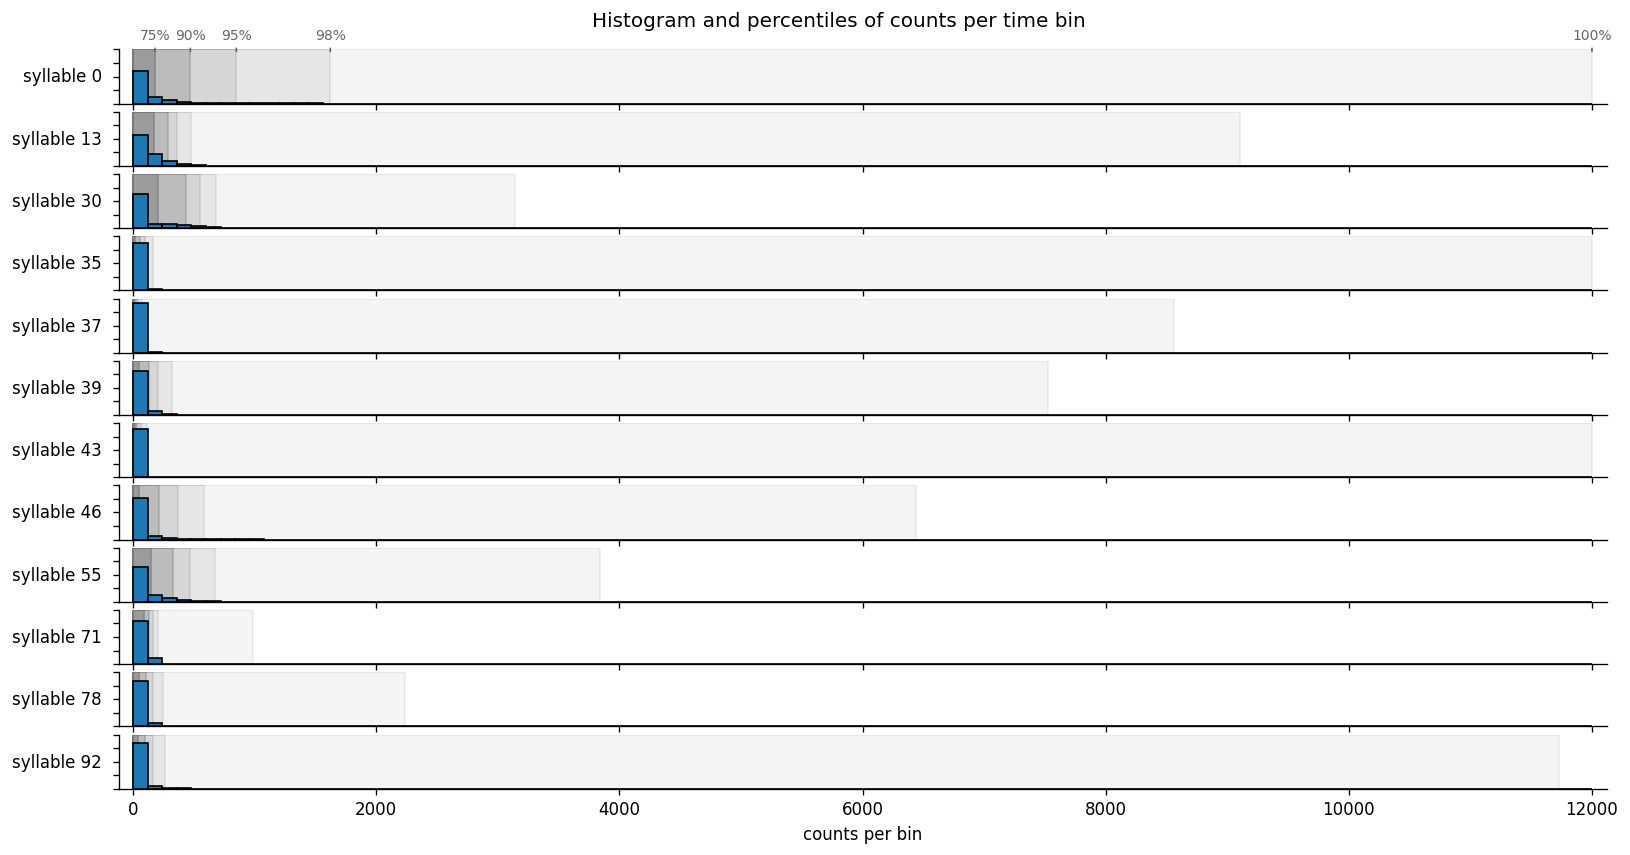

In [13]:
percentiles = [75, 90, 95, 98, 100]
alphas = [0.9, 0.4, 0.2, 0.15, 0.1]

# =============================================================================

fig, axs = plt.subplots(nrows=n_syllable_clusters, ncols=1,
                       sharex='all', sharey='all',
                       gridspec_kw={'hspace': 0.15,},
                       figsize=(16,8), dpi=120)

for i_row, syllable_idx in enumerate(syllable_cluster_idxs):
    ax = axs[i_row]
    
    # Extract syllable count usages
    these_counts = np.concatenate(
        [kf.syllable_counts[...,syllable_idx].ravel() for kf in kf_by_fish],
        axis=0
    )

    # Draw histogram
    ax.hist(these_counts, bins=100, range=(0, TOTAL_COUNTS_PER_BIN), ec='k',)
    
    # Draw percentile gradiations
    for pct, alpha in zip(percentiles, alphas):
        p = np.percentile(these_counts, pct)
        ax.fill_betweenx([0, 1], 0, p, transform=ax.get_xaxis_transform(),
                         color='0.6', alpha=alpha, ec='0.4')

        # Annotate the gradiations so folks know whats going on
        if i_row == 0:        
            ax.annotate(f'{pct}%',
                        xy=(p,0.9), xytext=(p,1.2), xycoords=ax.get_xaxis_transform(),
                        rotation=0, ha='center', va='baseline',
                        fontsize='small', c='0.4',
                        arrowprops={'arrowstyle': '-', 'color': '0.4'},
                       )
    # Label row
    ax.set_ylabel(f'syllable {syllable_idx}',
                  rotation=0, ha='right', va='center',
                  labelpad=10)

axs[-1].set_xlabel('counts per bin')

for ax in axs:
    ax.margins(x=0.01, y=0.1)
    ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=5))
    ax.tick_params(labelleft=False)

fig.suptitle('Histogram and percentiles of counts per time bin',
             fontsize='large', y=0.92)
sns.despine()

**Figure** | Histogram of counts per time bin across the cohort (_blue_), for selected syllables.
The gray backgrounds densities indicate the 75th, 90th, 95th, 98th, and 100th percentiles of the data.
This plot indicates that the 100th percentile (maximum value) is an extreme outlier for
each of syllables shown.

In [14]:
# Unable to make a boxen plot (violinplot without kde). Likely due to seaborn
# and pandas version incomptabilities; see: https://stackoverflow.com/a/76813458
# Resolving versions in Sherlock OnDemand is a headache, so I am skipping for now.

# (all_n_samples, N_SYLLABLES)
# all_counts = np.concatenate(
#     [kf.syllable_counts.reshape(-1, N_SYLLABLES) for kf in kf_by_fish],
#     axis=0
# )

# all_counts_df = pd.DataFrame(
#     all_counts,
#     columns=[f'{i}' for i in range(N_SYLLABLES)]
# )

# fig, ax = plt.subplots(figsize=(16,9), dpi=120)

# sns.boxenplot(
#     data=all_counts_df, 
#     ax=ax,
# )

## Min-max scaling

Now, let's apply the min max scaling to see how it affects the distributions.

In [16]:
mmn_syllable_counts = syllable_counts / syllable_counts.max(axis=(0,1))
mmn_syllable_counts = mmn_syllable_counts.reshape(-1, N_SYLLABLES)


In [ ]:
# I keep incurring a memory leak, so I am unable to make these plots at this time
# Grrrr

# fig, ax = plt.subplots(figsize=(16,3))
# ax.hist(mmn_syllable_counts[:, syllable_idx])

In [ ]:
# percentiles = [75, 90, 95, 98, 100]
# alphas = [0.9, 0.4, 0.2, 0.15, 0.1]

# # =============================================================================

# fig, axs = plt.subplots(nrows=n_syllable_clusters, ncols=1,
#                        sharex='all', sharey='all',
#                        gridspec_kw={'hspace': 0.15,},
#                        figsize=(8,8), dpi=120)

# for i_row, syllable_idx in enumerate(syllable_cluster_idxs):
#     ax = axs[i_row]
    
#     # Extract syllable count usages
#     these_counts = mmn_syllable_counts[:, syllable_idx]

#     # Draw histogram
#     ax.hist(these_counts, bins=30, range=(0, 1), ec='k',)
#     ax.set_xlim(0,1)
    
#     # Label row
#     ax.set_ylabel(f'syllable {syllable_idx}',
#                   rotation=0, ha='right', va='center',
#                   labelpad=10)

# axs[-1].set_xlabel('counts per bin')

# for ax in axs:
#     ax.margins(x=0.01, y=0.1)
#     ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=5))
#     ax.tick_params(labelleft=False)

# fig.suptitle('Histogram and percentiles of counts per time bin',
#              fontsize='large', y=0.92)
# sns.despine()